In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime, timedelta

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Load reforecasts (1993-2016) and forecasts (2017-2019)

In [2]:
model_name = 'ecmwfsipn'
model_type = 'reforecast'
no_day_change = 5

filepath_save = '/home/disk/sipn/mcmcgraw/data/VRILE/'
filename_full = filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                       model_type=model_type,d_days=no_day_change)
d_SIE = pd.read_csv(filename_full)
d_SIE_all = d_SIE.dropna()
d_SIE_all.head()

,Unnamed: 0,I (init date),V (valid date),SIE,lead time (days),d_SIE (V - I),ensemble,region
0,0,1993-01-01,1993-01-03,13.261036,2.0,0.046306,1.0,panArctic
1,1,1993-01-01,1993-01-04,13.268475,3.0,-0.003511,1.0,panArctic
2,2,1993-01-01,1993-01-05,13.230590,4.0,-0.003011,1.0,panArctic
3,3,1993-01-01,1993-01-06,13.224993,5.0,0.020101,1.0,panArctic
4,4,1993-01-01,1993-01-07,13.258025,6.0,0.077908,1.0,panArctic


In [3]:
#model_type_2 = 'forecast'
#filename_full_2 = filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
#                       model_type=model_type_2,d_days=no_day_change)
#d_SIE_forecast = pd.read_csv(filename_full_2)
#d_SIE_forecast_trim = d_SIE_forecast.dropna()
#d_SIE_forecast_trim = d_SIE_forecast_trim.drop(columns=['V_mon (valid date month)','V_yr (valid date year)'])
#d_SIE_forecast_trim.rename(columns={'d_SIC (V - I)':'d_SIE (V - I)'},inplace=True)
#d_SIE_forecast_trim.head()

Append forecast dataframe to reforecast

In [4]:
#d_SIE_all = d_SIE_all.append(d_SIE_forecast_trim)
#d_SIE_all = d_SIE_all[~d_SIE_all.index.duplicated()]
d_SIE_all.tail()

,Unnamed: 0,I (init date),V (valid date),SIE,lead time (days),d_SIE (V - I),ensemble,region
26315895,5270,2016-12-01,2017-06-27,2.853453,208.0,-0.031644,25.0,East-Siberian-Beaufort-Chukchi
26315896,5271,2016-12-01,2017-06-28,2.838418,209.0,-0.049046,25.0,East-Siberian-Beaufort-Chukchi
26315897,5272,2016-12-01,2017-06-29,2.834725,210.0,-0.059213,25.0,East-Siberian-Beaufort-Chukchi
26315898,5273,2016-12-01,2017-06-30,2.809419,211.0,-0.036510,25.0,East-Siberian-Beaufort-Chukchi
26315899,5274,2016-12-01,2017-07-01,2.794239,212.0,-0.031514,25.0,East-Siberian-Beaufort-Chukchi


Now load observations

In [5]:
obs_name = 'NSIDC_0079'
obs_type = 'sipn_nc_yearly_agg'
obs_filename = '/home/disk/sipn/mcmcgraw/data/VRILE/{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=obs_name,
                       model_type=obs_type,d_days=no_day_change)
SIE_obs = pd.read_csv(obs_filename)
SIE_obs = SIE_obs.dropna()

Get lists of regions and lead days

In [6]:
regions = d_SIE_all['region'].unique().tolist() #list unique regions
lead_days = d_SIE_all['lead time (days)'].unique().tolist() #list lead days

In [7]:
#SIE_lead_groups = d_SIE_all.groupby(['lead time (days)'])


Group model data by lead day and choose a lead day (here, we'll do first week, our earliest lead day).  Then group by region and find occasions where the 5th percentile of the modeled <code>n</code> -day change in SIE matches the 5th percentile of the observed 5-day change in SIE

In [8]:
pct_all = pd.DataFrame(columns={'Region',
                                    'Month',
                                    'Lead Days Group',
                                    'Obs 5th Pctile',
                                    'Obs 95th Pctile',
                                    'Model 5th Pctile',
                                    'Model 95th Pctile',
                                    'Model - Obs 5th Pctile',
                                    'Model - Obs 95th Pctile',
                                    'Model Pct of Obs',
                                    'Model Pct of Obs 95'})
pct_all_FULL = pd.DataFrame(columns={'Region',
                                    'Month',
                                    'Lead Days Group',
                                    'Obs 5th Pctile',
                                    'Obs 95th Pctile',
                                    'Model 5th Pctile',
                                    'Model 95th Pctile',
                                    'Model - Obs 5th Pctile',
                                    'Model - Obs 95th Pctile',
                                    'Model Pct of Obs',
                                    'Model Pct of Obs 95'})
for ilead in np.arange(0,4):
    lead_day_sel = (ilead*7)+1 + np.arange(0,7)
    SIE_lead_sel = d_SIE_all.loc[d_SIE_all['lead time (days)'].isin(lead_day_sel)]
    SIE_model_dates = pd.to_datetime(SIE_lead_sel['V (valid date)'])

    #Keep only observations that match dates associated with model lead times
    SIE_obs_dates = pd.to_datetime(SIE_obs['V (valid date)'])
    f_dates = SIE_obs_dates.isin(SIE_model_dates)
    SIE_obs_trim = SIE_obs.loc[f_dates]
    #region_choose = 'Central Arctic'
    #region_choose_ind = 0
    

    for imon in np.arange(0,12):
    #imon = 3
    #mon_sel = [6,7,8,9]
    #mon_sel_str = 'JJAS'
        mon_sel = imon + 1
        SIE_model_JJAS = SIE_lead_sel.loc[pd.to_datetime(SIE_lead_sel['V (valid date)']).dt.month.isin([mon_sel])]
        SIE_obs_JJAS_trim = SIE_obs_trim.loc[pd.to_datetime(SIE_obs_trim['V (valid date)']).dt.month.isin([mon_sel])]
        SIE_obs_JJAS_all = SIE_obs.loc[pd.to_datetime(SIE_obs['V (valid date)']).dt.month.isin([mon_sel])]
        for ireg in np.arange(0,len(regions)):
        #ireg=16
            save_ind = imon*len(regions) + ireg
            region_choose = regions[ireg]
            SIE_model_groups = SIE_model_JJAS.groupby(['region'])
            SIE_obs_trim_groups = SIE_obs_JJAS_trim.groupby(['region'])
            SIE_obs_all_groups = SIE_obs_JJAS_all.groupby(['region'])
            #
            SIE_model_sel = SIE_model_groups.get_group(region_choose)
            SIE_obs_trim_sel = SIE_obs_trim_groups.get_group(region_choose)
            SIE_obs_all_sel = SIE_obs_all_groups.get_group(region_choose)
            quantile_choose = 0.05

            SIE_model_match_obs = SIE_model_sel.loc[SIE_model_sel['d_SIE (V - I)'] < SIE_obs_trim_sel['d_SIC (V - I)'].quantile(quantile_choose)]
            pct = 100*(len(SIE_model_match_obs)/len(SIE_model_sel))
            pct_all.loc[save_ind,'Region'] = region_choose
            pct_all.loc[save_ind,'Month'] = mon_sel
            pct_all.loc[save_ind,'Lead Days Group'] = ilead
            #0: 0-7 (first week), 1: 8-15 (2nd week), 2: 16-22 (3rd week), 3: 23-end (4th week)
            pct_all.loc[save_ind,'Obs 5th Pctile'] = SIE_obs_trim_sel['d_SIC (V - I)'].quantile(quantile_choose)
            pct_all.loc[save_ind,'Model 5th Pctile'] = SIE_model_sel['d_SIE (V - I)'].quantile(quantile_choose)
            pct_all.loc[save_ind,'Model - Obs 5th Pctile'] = SIE_model_sel['d_SIE (V - I)'].quantile(quantile_choose) - SIE_obs_trim_sel['d_SIC (V - I)'].quantile(quantile_choose)
            pct_all.loc[save_ind,'Model Pct of Obs'] = pct

            SIE_model_match_obs_2 = SIE_model_sel.loc[SIE_model_sel['d_SIE (V - I)'] > SIE_obs_trim_sel['d_SIC (V - I)'].quantile(1-quantile_choose)]
            pct_2 = 100*(len(SIE_model_match_obs_2)/len(SIE_model_sel))
            pct_all.loc[save_ind,'Obs 95th Pctile'] = SIE_obs_trim_sel['d_SIC (V - I)'].quantile(1-quantile_choose)
            pct_all.loc[save_ind,'Model 95th Pctile'] = SIE_model_sel['d_SIE (V - I)'].quantile(1-quantile_choose)
            pct_all.loc[save_ind,'Model - Obs 95th Pctile'] = SIE_model_sel['d_SIE (V - I)'].quantile(1-quantile_choose) - SIE_obs_trim_sel['d_SIC (V - I)'].quantile(1-quantile_choose)
            pct_all.loc[save_ind,'Model Pct of Obs 95'] = pct_2
    pct_all_FULL = pct_all_FULL.append(pct_all)
#SIE_obs_trim_sel
#
#SIE_model_ens = SIE_model_sel.groupby(['ensemble'])
#SIE_ens_mean = SIE_model_ens.mean()

In [9]:
#SIE_model_sel.loc[SIE_model_sel['d_SIE (V - I)'] < SIE_obs_trim_sel['d_SIC (V - I)'].quantile(quantile_choose)]

pct_all_FULL['Lead Days Group'].unique().tolist()

[0, 1, 2, 3]

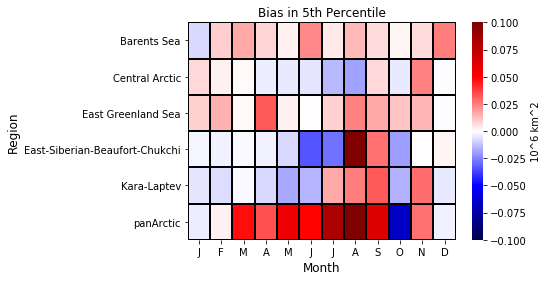

In [10]:
region_drop = ['Baffin Bay','Beaufort Sea','Bering','Canadian Islands','Chukchi Sea','East Siberian Sea',
              'Hudson Bay','Kara Sea','Laptev Sea','Sea of Okhotsk','St John']
pct_trimx = pct_all_FULL[~pct_all_FULL.Region.isin(region_drop)]
#pct_trimx.head()
lead_day_sel = 0
lead_group_max = [7,15,22,29]
pct_lead_groups = pct_trimx.groupby(['Lead Days Group'])
pct_trim = pct_lead_groups.get_group(lead_day_sel)

model_minus_obs_5th_pctile = pct_trim.pivot(index='Region',columns='Month',values='Model - Obs 5th Pctile')
model_minus_obs_5th_pctile = model_minus_obs_5th_pctile.astype(float)
import seaborn as sns
fig1 = plt.figure(1)
ax1 = sns.heatmap(model_minus_obs_5th_pctile,vmin=-0.1,vmax=0.1,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-0.1,0.1,9)})
ax1.set_xlabel('Month',fontsize=12)
ax1.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax1.set_ylabel('Region',fontsize=12)
ax1.set_title('Bias in {quant}th Percentile'.format(quant=5,model_name=model_name))
fpath_save = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/bias/chiclet_plots/'
fname_1 = fpath_save+'bias_in_5th_pctile_vs_month_model_{model_name}_minus_obs_region_LIM_lead_days_up_to_{lead_day_max}.pdf'.format(model_name=model_name,
                                                                                                                                lead_day_max=lead_group_max[lead_day_sel])
fig1.savefig(fname_1,format='pdf',bbox_inches='tight')

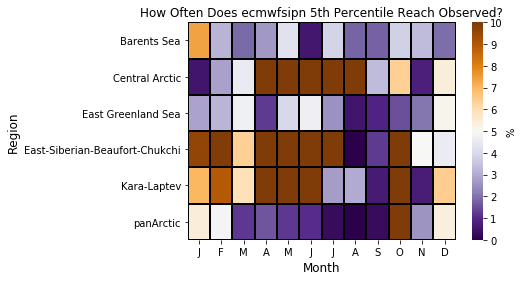

In [11]:
model_freq_obs_5th = pct_trim.pivot(index='Region',columns='Month',values='Model Pct of Obs')
model_freq_obs_5th = model_freq_obs_5th.astype(float)
fig2 = plt.figure(2)
ax2 = sns.heatmap(model_freq_obs_5th,vmin=0,vmax=10,cmap='PuOr_r',linewidths=1,
                  linecolor='k',cbar_kws={'label': '%',
                                          'ticks':np.linspace(0,10,11)})
ax2.set_xlabel('Month',fontsize=12)
ax2.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax2.set_ylabel('Region',fontsize=12)
ax2.set_title('How Often Does {model_name} {quant}th Percentile Reach Observed?'.format(quant=5,model_name=model_name))
fname_2 = fpath_save+'how_often_5th_pctile_vs_month_model_{model_name}_minus_obs_region_LIM_lead_days_up_to_{lead_day_max}.pdf'.format(model_name=model_name,
                                                                                                                                lead_day_max=lead_group_max[lead_day_sel])
fig2.savefig(fname_2,format='pdf',bbox_inches='tight')

In [12]:
pct_all.loc[pct_all['Region']=='panArctic']

,Lead Days Group,Model - Obs 95th Pctile,Model - Obs 5th Pctile,Model Pct of Obs,Obs 95th Pctile,Region,Month,Model 5th Pctile,Model 95th Pctile,Model Pct of Obs 95,Obs 5th Pctile
0,3,0.0221419,-0.001943,5.2381,0.293931,panArctic,1,-0.0533639,0.316073,7.47619,-0.0514209
17,3,-0.0672748,0.0940079,0.57947,0.25117,panArctic,2,-0.174255,0.183895,1.21413,-0.268263
34,3,-0.0609298,0.0357751,2.08801,0.147711,panArctic,3,-0.224141,0.0867816,1.43691,-0.259916
51,3,0.0061195,0.0975426,0.261905,-0.0283884,panArctic,4,-0.251103,-0.0222689,5.90476,-0.348646
68,3,0.00819375,0.067457,0.44335,-0.0653971,panArctic,5,-0.250747,-0.0572033,6.55172,-0.318204
85,3,0.0152951,0.178318,0,-0.132232,panArctic,6,-0.357044,-0.116937,8.28571,-0.535362
102,3,0.0361237,0.126981,0.0714286,-0.136588,panArctic,7,-0.360769,-0.100464,12.7857,-0.48775
119,3,0.0673111,0.184709,0,-0.0570673,panArctic,8,-0.191359,0.0102438,32.7619,-0.376068
136,3,-0.16713,0.016672,2.88095,0.412686,panArctic,9,0.00163077,0.245556,0.166667,-0.0150412
153,3,0.126237,0.054431,1.73594,0.601203,panArctic,10,0.187355,0.72744,13.0562,0.132924


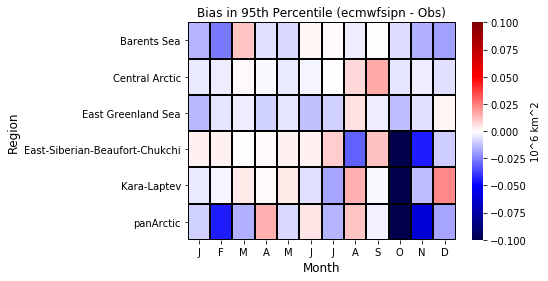

In [13]:
model_minus_obs_95th_pctile = pct_trim.pivot(index='Region',columns='Month',values='Model - Obs 95th Pctile')
model_minus_obs_95th_pctile = model_minus_obs_95th_pctile.astype(float)
fig3 = plt.figure(3)
ax3 = sns.heatmap(model_minus_obs_95th_pctile,vmin=-0.1,vmax=0.1,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-0.1,0.1,9)})
ax3.set_xlabel('Month',fontsize=12)
ax3.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax3.set_ylabel('Region',fontsize=12)
ax3.set_title('Bias in {quant}th Percentile ({model_name} - Obs)'.format(quant=95,model_name=model_name))
fpath_save = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/bias/chiclet_plots/'
fname_3 = fpath_save+'bias_in_95th_pctile_vs_month_model_{model_name}_minus_obs_region_LIM_lead_days_up_to_{lead_day_max}.pdf'.format(model_name=model_name,
                                                                                                                                lead_day_max=lead_group_max[lead_day_sel])
fig3.savefig(fname_3,format='pdf',bbox_inches='tight')

In [14]:
#pct_trim

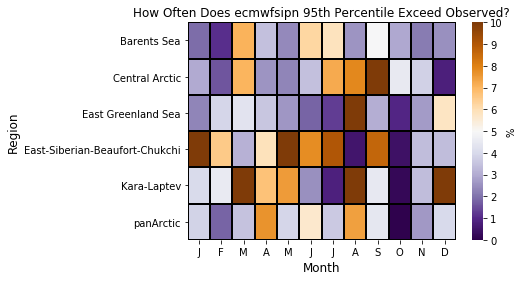

In [15]:
model_freq_obs_95th = pct_trim.pivot(index='Region',columns='Month',values='Model Pct of Obs 95')
model_freq_obs_95th = model_freq_obs_95th.astype(float)
fig4 = plt.figure(4)
ax4 = sns.heatmap(model_freq_obs_95th,vmin=0,vmax=10,cmap='PuOr_r',linewidths=1,
                  linecolor='k',cbar_kws={'label': '%',
                                          'ticks':np.linspace(0,10,11)})
ax4.set_xlabel('Month',fontsize=12)
ax4.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax4.set_ylabel('Region',fontsize=12)
ax4.set_title('How Often Does {model_name} {quant}th Percentile Exceed Observed?'.format(quant=95,model_name=model_name))
fname_4 = fpath_save+'how_often_95th_pctile_vs_month_model_{model_name}_minus_obs_region_LIM_lead_days_up_to_{lead_day_max}.pdf'.format(model_name=model_name,
                                                                                                                                lead_day_max=lead_group_max[lead_day_sel])
fig4.savefig(fname_4,format='pdf',bbox_inches='tight')

In [37]:
pct_trimx

,Model 95th Pctile,Region,Model Pct of Obs 95,Month,Model - Obs 95th Pctile,Model Pct of Obs,Lead Days Group,Model 5th Pctile,Obs 95th Pctile,Obs 5th Pctile,Model - Obs 5th Pctile
0,0.340041,panArctic,3.83333,1,-0.00924541,5.44444,0,-0.0232774,0.349287,-0.0196792,0.00359821
6,0.0610416,East Greenland Sea,2.30556,1,-0.0140238,2.88889,0,-0.0597659,0.0750653,-0.0688468,-0.00908088
7,0.0877325,Barents Sea,1.91667,1,-0.0141969,7.41667,0,-0.0733463,0.101929,-0.0656738,0.00767251
14,0.00853123,Central Arctic,2.97222,1,-0.00415318,0.583333,0,-0.00722189,0.0126844,-0.0148909,-0.00766903
15,0.0238007,Kara-Laptev,4.02778,1,-0.00396149,7,0,-0.0118829,0.0277622,-0.00691405,0.00496886
16,0.00250412,East-Siberian-Beaufort-Chukchi,15.3611,1,0.00250412,9.63889,0,-0.00188854,0,0,0.00188854
17,0.235475,panArctic,1.81347,2,-0.0443698,4.89349,0,-0.0674135,0.279845,-0.0699319,-0.00251838
23,0.0767123,East Greenland Sea,3.90805,2,-0.00500828,3.21839,0,-0.0871332,0.0817206,-0.102436,-0.0153023
24,0.0745242,Barents Sea,1.12069,2,-0.0263569,3.18966,0,-0.0616485,0.100881,-0.0711116,-0.00946307
31,0.0131351,Central Arctic,1.6092,2,-0.00374873,2.81609,0,-0.00787487,0.0168839,-0.0108481,-0.00297328
